In [28]:
import ROOT
import uproot
import math
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

In [ ]:
# 打开 ROOT 文件，载入 events tree
Threshold_i=0.5
Threshold=Threshold_i*0.0410
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
SamplingLayer=30
ECAL_layers=60
Si=0.15  # mm
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, SamplingLayer))
    N_layers_all = np.empty((0, SamplingLayer))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, SamplingLayer))
    N_layers_all = np.empty((0, SamplingLayer))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=SamplingLayer)
        N_layers_event = np.bincount(layers, minlength=SamplingLayer)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
DataPath_Uniform=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
E_layers_test, N_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_la

length after zero suppression: 1249683 1249683 1249683 1249683 1249683
length after zero suppression: 59988 59988 59988 59988 59988


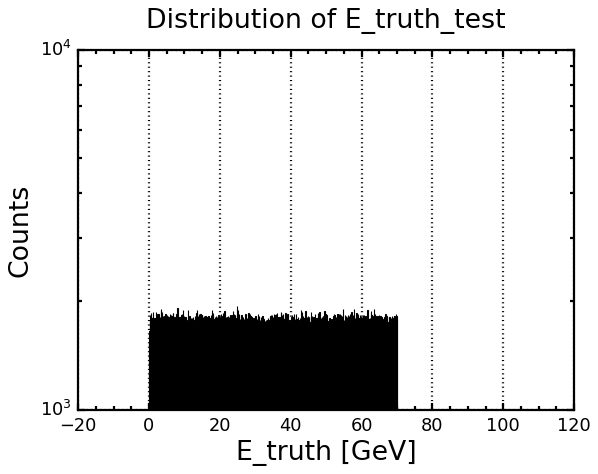

In [30]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, E_truth_test)
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(E_truth_uniform, bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()

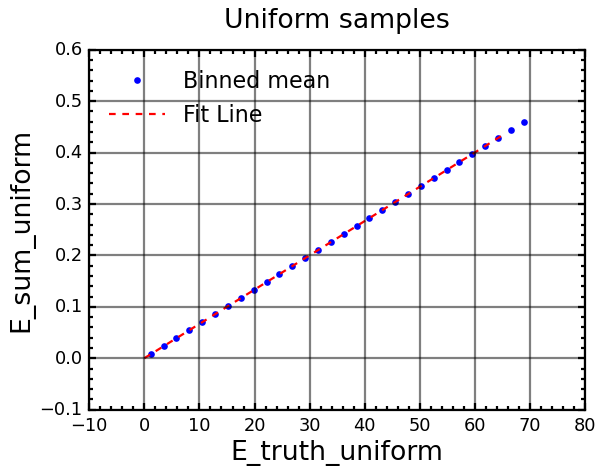

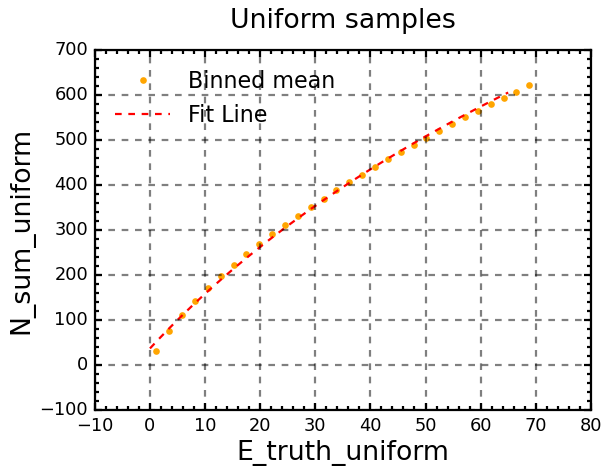

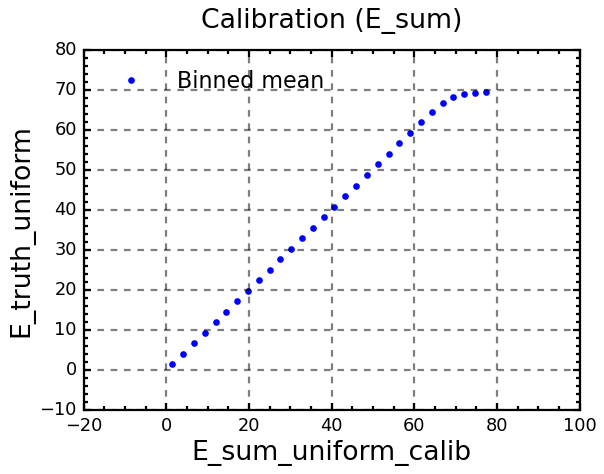

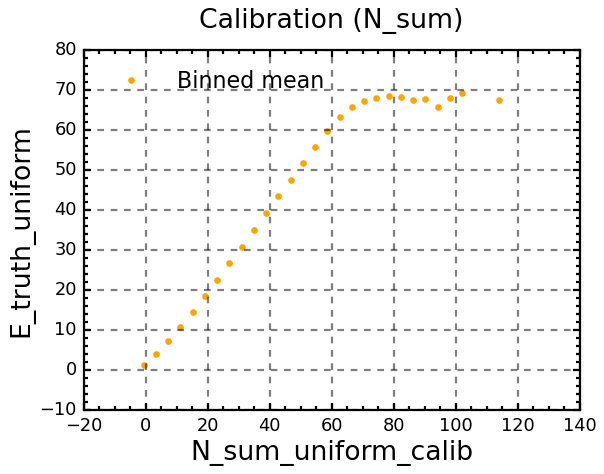

In [31]:
def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

fit_range = (0, 65)
mask_fit = (E_truth_uniform > fit_range[0]) & (E_truth_uniform < fit_range[1])
# E_sum: linear
coeffs_calibE = np.polyfit(E_sum_uniform[mask_fit], E_truth_uniform[mask_fit], 1)
coeffs_calibE_inv = np.polyfit(E_truth_uniform[mask_fit], E_sum_uniform[mask_fit], 1)
E_fit_line = np.poly1d(coeffs_calibE_inv)
# N_sum: exponential
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform[mask_fit], E_truth_uniform[mask_fit], p0=(1,0.01,1))
E_fit = exp_func(N_sum_uniform, *coeffs_calibN)
interp_inv = interp1d(E_fit, N_sum_uniform, bounds_error=False, fill_value="extrapolate")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, E_sum_uniform, color="blue", label="Binned mean")
X_line=np.linspace(fit_range[0], fit_range[1], 200)
plt.plot(X_line, E_fit_line(X_line), color="red", linestyle="--", label="Fit Line")
plt.ylabel("E_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="-", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, N_sum_uniform, color="orange", label="Binned mean")
E_vals = np.linspace(fit_range[0], fit_range[1], 200)
N_vals = interp_inv(E_vals)
plt.plot(E_vals, N_vals, color="red", linestyle="--", label="Fit Line")
plt.ylabel("N_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

E_calib = np.poly1d(coeffs_calibE)
E_sum_uniform_calib = E_calib(E_sum_uniform)
#E_sum_train_calib   = E_calib(E_sum_train)
E_sum_test_calib    = E_calib(E_sum_test)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
#N_sum_train_calib   = exp_func(N_sum_train, *coeffs_calibN)
N_sum_test_calib    = exp_func(N_sum_test, *coeffs_calibN)

plt.figure(figsize=fig_size)
plot_binned(E_sum_uniform_calib,E_truth_uniform, color="blue", label="Binned mean")
plt.xlabel("E_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (E_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(N_sum_uniform_calib, E_truth_uniform, color="orange", label="Binned mean")
plt.xlabel("N_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (N_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")
plt.show()

In [32]:
from sklearn import base


class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        # base = torch.where(abs_rel < self.delta,
        #            0.5 * rel**2,
        #            self.delta * (abs_rel - 0.5*self.delta))
        # loss = base * (1 + abs_rel)
        return torch.mean(loss)

class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.activation(x)
        #out = x
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        prev_dim = input_dim
        print(f"Input dim: {input_dim}")
        for h in hidden_dims:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h
        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
        x = self.model(x)
        return self.output_layer(x).squeeze(-1)

# ==== Training function ====
def train_mlp(X_train,y_train,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
              hidden_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=500,
              patience=10,
              val_split=0.2,
              random_state=42):
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    val_split = 0.2
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=val_split, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_validate_tensor = torch.tensor(X_validate_scaled, dtype=torch.float32)
    y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_validate_tensor, y_validate_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(X_train)}, Validation samples: {int(len(X_validate))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")
    # Model
    model = MLPRegressor(input_dim=X_train.shape[1], hidden_dims=hidden_dims, dropout=dropout,
                         activation=activation).to(device)

    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = 2 * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item() * xb.size(0)

        train_loss /= len(train_dataset)
        val_loss   /= len(val_dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    y_validate_pred = model(X_validate_tensor.to(device)).cpu().detach().numpy()
    return model,scaler,y_validate, y_validate_pred

In [33]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
#performance not good
# E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
# N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
# E_layers_test_exp    = np.exp(E_layers_test_ratio)
# N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
#EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
#EN_layers_test    = E_N_layers_test * N_layers_test

LayerNum_uniform = np.array([np.sum(e>0) for e in E_layers_uniform])
LayerNum_test    = np.array([np.sum(e>0) for e in E_layers_test])
Average_E_layer_uniform = E_sum_uniform / (LayerNum_uniform + 1e-6) 
Average_E_layer_test    = E_sum_test / (LayerNum_test + 1e-6)
Average_N_layer_uniform = N_sum_uniform / (LayerNum_uniform + 1e-6)
Average_N_layer_test    = N_sum_test / (LayerNum_test + 1e-6)

In [34]:
X_train = np.hstack([
    E_layers_uniform, 
    E_layers_uniform_ratio,
    E_sum_uniform_calib[:, np.newaxis],
    N_layers_uniform, 
    N_layers_uniform_ratio,
    N_sum_uniform_calib[:, np.newaxis],
    E_N_layers_uniform,
    LayerNum_uniform[:, np.newaxis],
    Average_E_layer_uniform[:, np.newaxis],
    Average_N_layer_uniform[:, np.newaxis],
])
X_test = np.hstack(
    [E_layers_test, 
    E_layers_test_ratio,
    E_sum_test_calib[:,np.newaxis], 
    N_layers_test, 
    N_layers_test_ratio,
    N_sum_test_calib[:,np.newaxis],
    E_N_layers_test,
    LayerNum_test[:, np.newaxis],
    Average_E_layer_test[:, np.newaxis],
    Average_N_layer_test[:, np.newaxis],
])
y_train = E_truth_uniform
y_test = E_truth_test

def plot_features_in_batches(X, feature_names=None, bins=50, n_cols=2, figsize=(12, 6)):
    n_features = X.shape[1]
    n_rows = (n_cols + n_cols - 1) // n_cols  # 每页只有 1 行 2 列的话 n_rows=1
    for start in range(0, n_features, n_cols):
        end = min(start + n_cols, n_features)
        plt.figure(figsize=figsize)
        for i, j in enumerate(range(start, end)):
            plt.subplot(1, n_cols, i + 1)
            plt.hist(X[:, j], bins=bins, color='skyblue', edgecolor='black')
            plt.yscale('log')
            if feature_names:
                plt.title(feature_names[j], fontsize=10)
            else:
                plt.title(f"Feature {j}", fontsize=10)
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.show()
#plot_features_in_batches(X_train, bins=50, n_cols=2, figsize=(12, 6))

Using device: cuda
Random state: 42
Training samples: 999746, Validation samples: 249937
learning rate: 0.001, batch size: 4096, epochs: 50, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Input dim: 155
Epoch 001/50 | Train Loss: 0.089800 | Val Loss: 0.018586| LR: 0.000400
Epoch 002/50 | Train Loss: 0.014893 | Val Loss: 0.008111| LR: 0.000600
Epoch 003/50 | Train Loss: 0.009246 | Val Loss: 0.006083| LR: 0.000800
Epoch 004/50 | Train Loss: 0.007455 | Val Loss: 0.006380| LR: 0.001000
Epoch 005/50 | Train Loss: 0.006245 | Val Loss: 0.003621| LR: 0.001000
Epoch 006/50 | Train Loss: 0.005449 | Val Loss: 0.003528| LR: 0.000995
Epoch 007/50 | Train Loss: 0.004825 | Val Loss: 0.002846| LR: 0.000981
Epoch 008/50 | Train Loss: 0.003962 | Val Loss: 0.002457| LR: 0.000957
Epoch 009/50 | Train Loss: 0.003766 | Val Loss: 0.002333| LR: 0.000924
Epoch 010/50 | Train Loss: 0.003202 | Val Loss: 0.003074| LR: 0.000883
Epoch 01

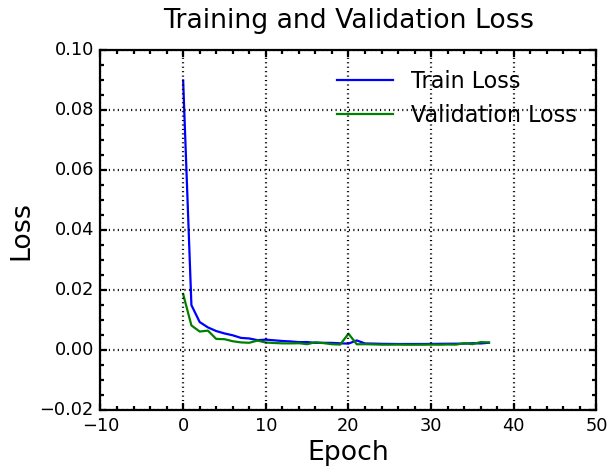

In [ ]:
ParameterScan=[1e-3,]#not used, but the loop is kept for future parameter scanning
Reco_hist_mlp_all = []
MLP_Config="lr1e-3"
for lr in ParameterScan:
  mlp_model,scaler,y_validate, y_validate_pred = train_mlp(X_train, y_train,
                    activation=nn.PReLU(),
                    hidden_dims=[128, 64, 32],
                      dropout=0.1,
                      loss=HuberRelativeLoss(delta=0.1),
                      lr=5e-4,
                      weight_decay=1e-5,
                      batch_size=4096,
                      epochs=50,
                      patience=10,
                      random_state=42)
  device = next(mlp_model.parameters()).device
  torch.save(mlp_model, DataPath_Validate+f"/Models/MLP.pth")

Step 1 Linear fit coeffs: [ 0.00100149 -0.04462372]


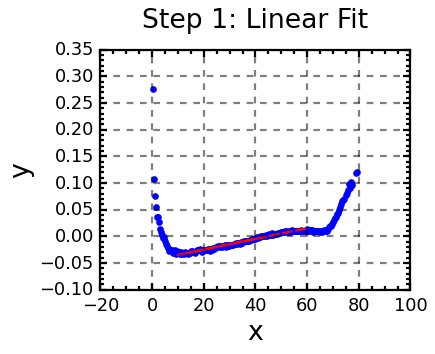

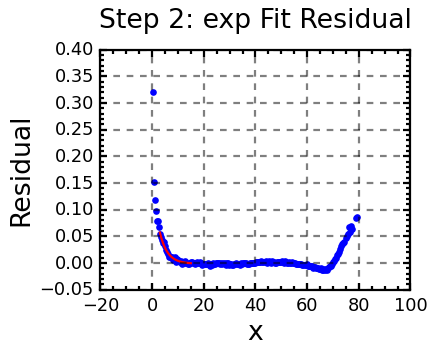

Step 3 Linear fit coeffs: [ 0.00103628 -0.04497385]


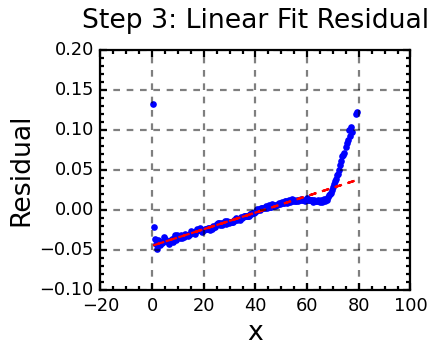

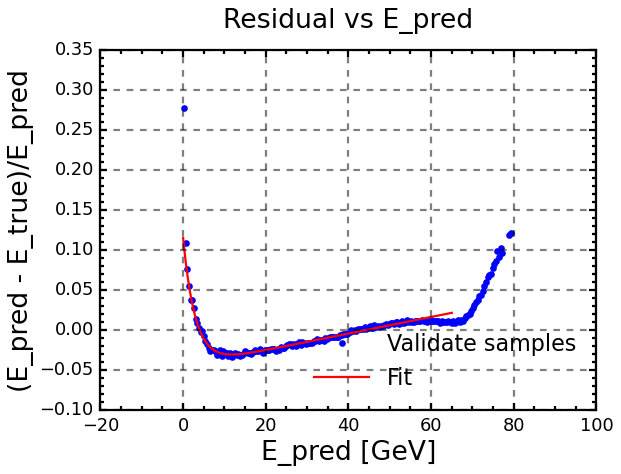

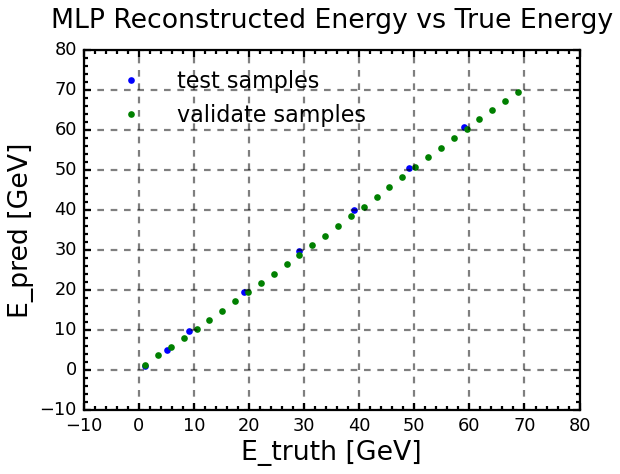

In [46]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (3, 15)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > linear_range[0]) & (x < linear_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

y_pred=y_validate_pred
y_true=y_validate
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_test_mlp = mlp_model(X_test_tensor).detach().cpu().numpy()
Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp, E_truth_test, Energy_test, Nbins=50)
Reco_hist_mlp_all.append(Reco_hist_mlp)

fit_range = (0, 65) 
mask = y_pred>0
residual_E = (y_pred[mask] - y_true[mask]) / y_pred[mask]
E_calib_fit = Combined_fit(y_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
x_fit = np.linspace(fit_range[0], fit_range[1], 200)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
#plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
y_pred_test_mlp_calib = y_pred_test_mlp*(1-E_calib_fit(y_pred_test_mlp))
Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp_calib, E_truth_test, Energy_test, Nbins=50)
Reco_hist_mlp_all.append(Reco_hist_mlp)

plt.figure(figsize=fig_size)
plot_binned(y_test, y_pred_test_mlp, color="blue", label="test samples")
plot_binned(y_true, y_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [47]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


In [48]:
# #This cell is left here for debug
# print("length of Reco_hist_mlp_all:", len(Reco_hist_mlp_all))
# Reco_hist_mlp = Reco_hist_mlp_all[0] # Example for first beta
# print("length of Reco_hist_mlp:", len(Reco_hist_mlp))
# i_E = 6 # Example index, change as needed
# #print(len(Reco_hist_mlp))
# #print(Reco_hist_mlp[i_E])
# mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
#     "E_reco",Reco_hist_mlp[i_E]["E_truth"],Reco_hist_mlp[i_E]["counts"],Reco_hist_mlp[i_E]["bin_edges"])

Mean: 0.1883617314352462, Peak: 0.16800762766149469, RMS: 0.05013954111427445
Initial Gamma Fit Parameters: [np.float64(56.284149629681885), np.float64(4.129728305398412), np.float64(-0.018700950724060417), np.float64(0.05013954111427445)]
Gamma Fit Bounds: lower [np.float64(0.5628414962968189), np.float64(-0.5870271694601588), np.float64(-1.001870095072406), np.float64(0.005013954111427445)], 
 upper [np.float64(337.7048977780913), np.float64(41.297283053984124), np.float64(9.97194857391391), np.float64(0.5013954111427444)]
Gamma Fit Parameters: [ 5.57609542e+01  4.12972831e+01 -1.20497298e-01  7.50393800e-03]
Gamma Fit Peak: 0.18189101566404586 ± 0.0015871477252429843, Mean: 0.1893949536648457 ± 0.0016031748592191589, Resolution: 0.26511770360147313 ± 0.006879420517273424


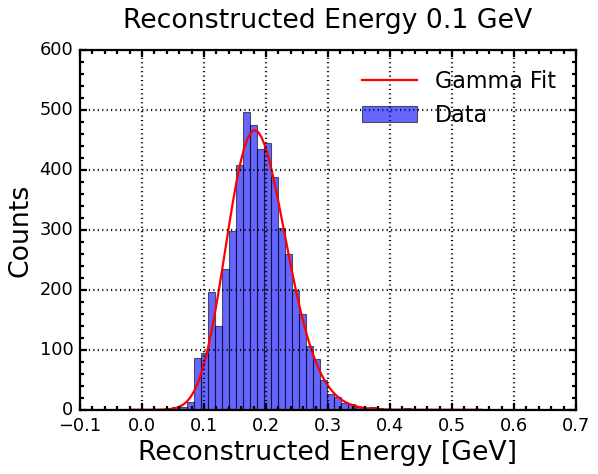

appending results for E = 0.1
Mean_Gamma: 0.1893949536648457 Mean_Gamma_Error: 0.0016031748592191589
Peak_Gamma: 0.18189101566404586 Peak_Gamma_Error: 0.0015871477252429843
Mean: 0.3132365108104908, Peak: 0.2956588248241029, RMS: 0.06642887092996323
Initial Gamma Fit Parameters: [np.float64(64.3407132223517), np.float64(3.657302571894916), np.float64(0.07028603031026086), np.float64(0.06642887092996323)]
Gamma Fit Bounds: lower [np.float64(0.643407132223517), np.float64(-0.6342697428105084), np.float64(-0.992971396968974), np.float64(0.006642887092996323)], 
 upper [np.float64(386.0442793341102), np.float64(36.57302571894916), np.float64(10.10542904546539), np.float64(0.6642887092996324)]
Gamma Fit Parameters: [6.23985993e+01 1.62289686e+01 7.67736030e-02 1.44499715e-02]
Gamma Fit Peak: 0.2968317651658257 ± 0.0009944290702056649, Mean: 0.3112817366773391 ± 0.0010204172001534154, Resolution: 0.19611105496549516 ± 0.00282897722829974


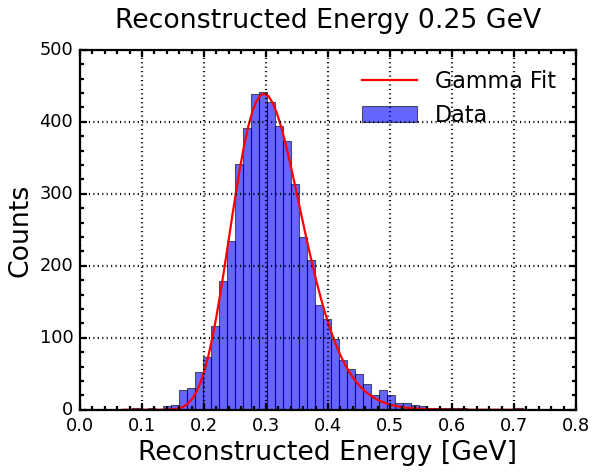

appending results for E = 0.25
Mean_Gamma: 0.3112817366773391 Mean_Gamma_Error: 0.0010204172001534154
Peak_Gamma: 0.2968317651658257 Peak_Gamma_Error: 0.0009944290702056649
Mean: 0.5450773580916158, Peak: 0.5205781630700856, RMS: 0.117688656228063
Initial Gamma Fit Parameters: [np.float64(100.5146787206093), np.float64(3.7105684634043286), np.float64(0.10838554179133189), np.float64(0.117688656228063)]
Gamma Fit Bounds: lower [np.float64(1.005146787206093), np.float64(-0.6289431536595671), np.float64(-0.9891614458208668), np.float64(0.011768865622806301)], 
 upper [np.float64(603.0880723236558), np.float64(37.105684634043286), np.float64(10.162578312686998), np.float64(1.17688656228063)]
Gamma Fit Parameters: [9.93325147e+01 1.68969054e+01 8.17577999e-02 2.73391204e-02]
Gamma Fit Peak: 0.5163652111325996 ± 0.002095327684944171, Mean: 0.5437043314983776 ± 0.0021477762948002165, Resolution: 0.2176362072525503 ± 0.0034511765561530197


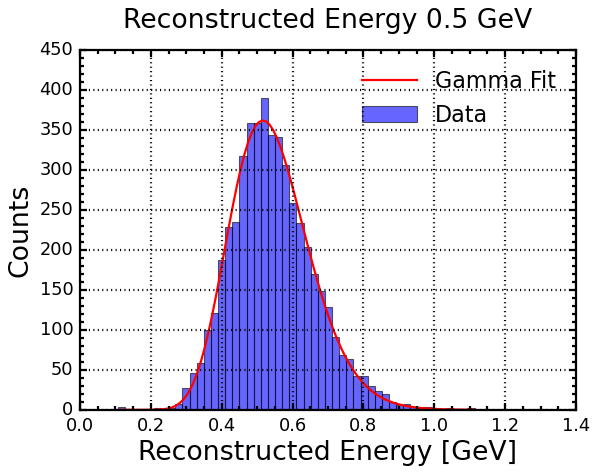

appending results for E = 0.5
Mean_Gamma: 0.5437043314983776 Mean_Gamma_Error: 0.0021477762948002165
Peak_Gamma: 0.5163652111325996 Peak_Gamma_Error: 0.002095327684944171
Mean: 1.0520442652471416, Peak: 1.0303143292254289, RMS: 0.17694930698197744
Initial Gamma Fit Parameters: [np.float64(154.01552598114924), np.float64(4.2161085872073345), np.float64(0.30600677258003967), np.float64(0.17694930698197744)]
Gamma Fit Bounds: lower [np.float64(1.5401552598114925), np.float64(-0.5783891412792665), np.float64(-0.969399322741996), np.float64(0.017694930698197744)], 
 upper [np.float64(924.0931558868954), np.float64(42.16108587207334), np.float64(10.45901015887006), np.float64(1.7694930698197744)]
Gamma Fit Parameters: [ 1.53631757e+02  4.21610859e+01 -8.02092972e-02  2.69020443e-02]
Gamma Fit Peak: 1.0271080601248976 ± 0.0031147553857320764, Mean: 1.0540101044671162 ± 0.003145119778807583, Resolution: 0.17006895405407224 ± 0.002246759731500725


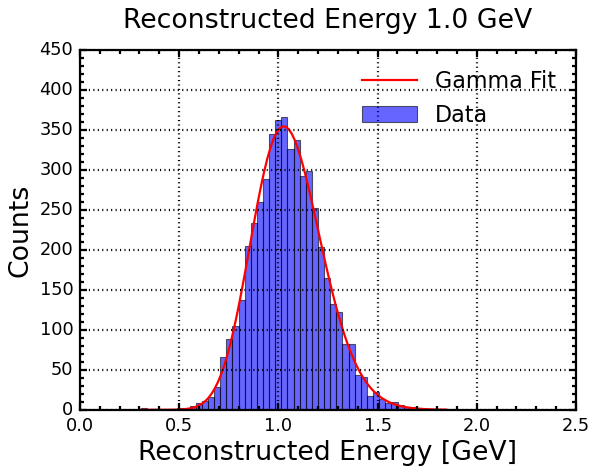

appending results for E = 1.0
Mean_Gamma: 1.0540101044671162 Mean_Gamma_Error: 0.003145119778807583
Peak_Gamma: 1.0271080601248976 Peak_Gamma_Error: 0.0031147553857320764
Mean: 2.0367726104909196, Peak: 1.9988602448146313, RMS: 0.2728551373748482
Initial Gamma Fit Parameters: [np.float64(195.42943587353275), np.float64(3.0767010413013427), np.float64(1.1972789252053033), np.float64(0.2728551373748482)]
Gamma Fit Bounds: lower [np.float64(1.9542943587353276), np.float64(-0.6923298958698657), np.float64(-0.8802721074794697), np.float64(0.02728551373748482)], 
 upper [np.float64(1172.5766152411966), np.float64(30.767010413013427), np.float64(11.795918387807955), np.float64(2.728551373748482)]
Gamma Fit Parameters: [1.95171499e+02 3.07081464e+01 5.28147736e-01 4.92114195e-02]
Gamma Fit Peak: 1.9901277904816306 ± 0.00686707342736559, Mean: 2.039339209976659 ± 0.006960120245475155, Resolution: 0.1370287604706352 ± 0.002585284981957565


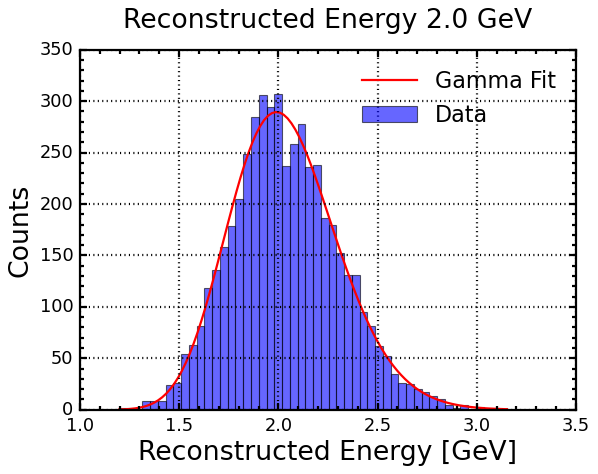

appending results for E = 2.0
Mean_Gamma: 2.039339209976659 Mean_Gamma_Error: 0.006960120245475155
Peak_Gamma: 1.9901277904816306 Peak_Gamma_Error: 0.00686707342736559
Mean: 5.0596342848519615, Peak: 5.04017584874588, RMS: 0.46813474238491337
Initial Gamma Fit Parameters: [np.float64(395.02723133247713), np.float64(3.504741624370955), np.float64(3.4189429674013816), np.float64(0.46813474238491337)]
Gamma Fit Bounds: lower [np.float64(3.9502723133247715), np.float64(-0.6495258375629045), np.float64(-0.6581057032598618), np.float64(0.04681347423849134)], 
 upper [np.float64(2370.1633879948627), np.float64(35.04741624370955), np.float64(15.128414451102072), np.float64(4.681347423849134)]
Gamma Fit Parameters: [3.96663208e+02 3.50474162e+01 2.26568984e+00 8.02409355e-02]
Gamma Fit Peak: 4.997686368086198 ± 0.009493894864572318, Mean: 5.077927303598013 ± 0.009605268907960313, Resolution: 0.09505062750732698 ± 0.0013733753016341853


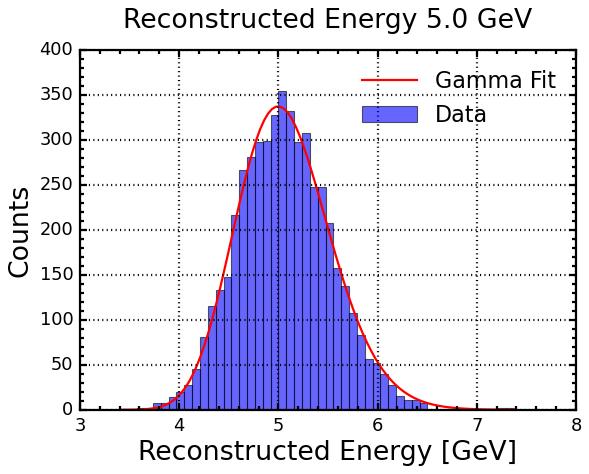

appending results for E = 5.0
Mean_Gamma: 5.077927303598013 Mean_Gamma_Error: 0.009605268907960313
Peak_Gamma: 4.997686368086198 Peak_Gamma_Error: 0.009493894864572318
Mean: 10.065070941839085, Peak: 9.94161523866935, RMS: 0.6951232490147788
Initial Gamma Fit Parameters: [np.float64(604.2221201855474), np.float64(4.263801785729449), np.float64(7.101203191387815), np.float64(0.6951232490147788)]
Gamma Fit Bounds: lower [np.float64(6.042221201855474), np.float64(-0.5736198214270551), np.float64(-0.2898796808612185), np.float64(0.06951232490147789)], 
 upper [np.float64(3625.3327211132846), np.float64(42.638017857294486), np.float64(20.651804787081723), np.float64(6.951232490147788)]
Gamma Fit Parameters: [5.99992813e+02 4.26380179e+01 5.63768272e+00 1.04384673e-01]
Gamma Fit Peak: 9.984053579575138 ± 0.012318352815217747, Mean: 10.088438252166412 ± 0.012436624362079436, Resolution: 0.06826975337168414 ± 0.0008658720729049705


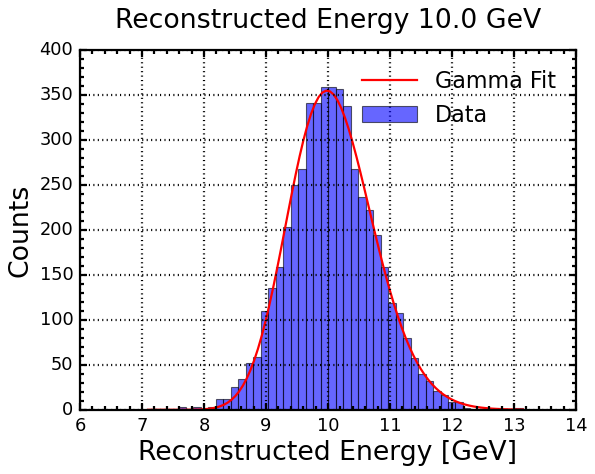

appending results for E = 10.0
Mean_Gamma: 10.088438252166412 Mean_Gamma_Error: 0.012436624362079436
Peak_Gamma: 9.984053579575138 Peak_Gamma_Error: 0.012318352815217747
Mean: 20.057723298279704, Peak: 20.00690300584052, RMS: 0.9904590132969301
Initial Gamma Fit Parameters: [np.float64(786.0927258926981), np.float64(3.467485832300453), np.float64(16.623320702198313), np.float64(0.9904590132969301)]
Gamma Fit Bounds: lower [np.float64(7.860927258926981), np.float64(-0.6532514167699547), np.float64(0.6623320702198314), np.float64(0.09904590132969301)], 
 upper [np.float64(4716.556355356189), np.float64(34.67485832300453), np.float64(34.93498105329747), np.float64(9.9045901329693)]
Gamma Fit Parameters: [7.86613848e+02 3.46748583e+01 1.42154976e+01 1.69847636e-01]
Gamma Fit Peak: 19.935092707034112 ± 0.020337703704865442, Mean: 20.104940342893784 ± 0.020578970613030736, Resolution: 0.05017051905673381 ± 0.0007228390248739949


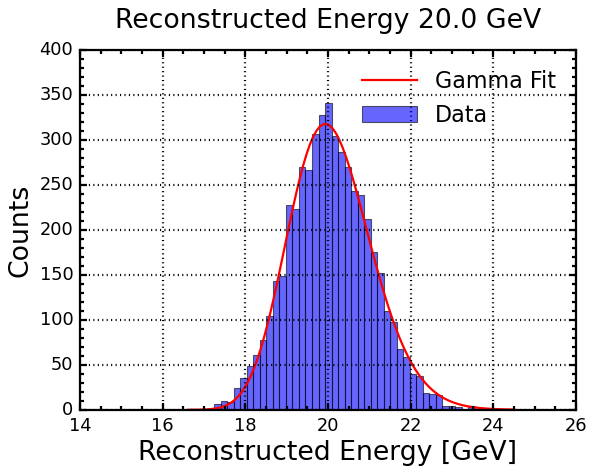

appending results for E = 20.0
Mean_Gamma: 20.104940342893784 Mean_Gamma_Error: 0.020578970613030736
Peak_Gamma: 19.935092707034112 Peak_Gamma_Error: 0.020337703704865442
Mean: 30.050812802133617, Peak: 29.62611206976399, RMS: 1.2732546633727737
Initial Gamma Fit Parameters: [np.float64(1223.1581441264175), np.float64(4.851343226337631), np.float64(23.87381741557731), np.float64(1.2732546633727737)]
Gamma Fit Bounds: lower [np.float64(12.231581441264176), np.float64(-0.5148656773662368), np.float64(1.3873817415577312), np.float64(0.12732546633727737)], 
 upper [np.float64(7338.948864758505), np.float64(48.513432263376316), np.float64(45.81072612336597), np.float64(12.732546633727736)]
Gamma Fit Parameters: [1.22106935e+03 4.85134323e+01 2.13444430e+01 1.80604011e-01]
Gamma Fit Peak: 29.92555948898638 ± 0.03137265384382175, Mean: 30.10616350027423 ± 0.0316366907549905, Resolution: 0.04203548996872366 ± 0.0007207447903386036


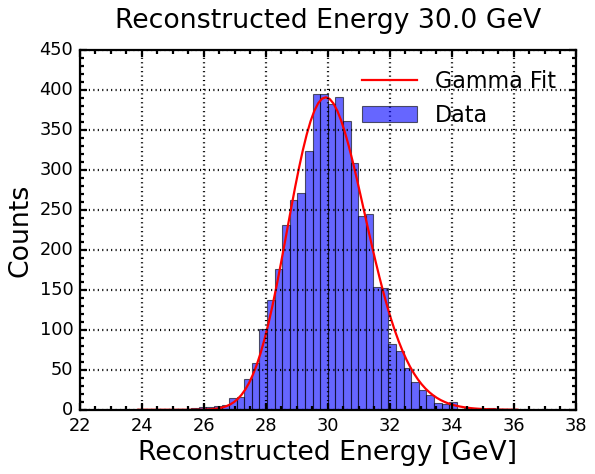

appending results for E = 30.0
Mean_Gamma: 30.10616350027423 Mean_Gamma_Error: 0.0316366907549905
Peak_Gamma: 29.92555948898638 Peak_Gamma_Error: 0.03137265384382175
Mean: 40.10823719485381, Peak: 39.9689568529423, RMS: 1.5190285294499066
Initial Gamma Fit Parameters: [np.float64(1268.9084519318142), np.float64(4.185685398363536), np.float64(33.7500616594377), np.float64(1.5190285294499066)]
Gamma Fit Bounds: lower [np.float64(12.689084519318142), np.float64(-0.5814314601636463), np.float64(2.37500616594377), np.float64(0.15190285294499067)], 
 upper [np.float64(7613.4507115908855), np.float64(41.85685398363536), np.float64(60.62509248915654), np.float64(15.190285294499066)]
Gamma Fit Parameters: [1.26206777e+03 4.18568540e+01 3.05649402e+01 2.29183445e-01]
Gamma Fit Peak: 39.92865474974359 ± 0.026615712015366028, Mean: 40.157838194620936 ± 0.02687643531398174, Resolution: 0.03713486557313782 ± 0.00046234240828184916


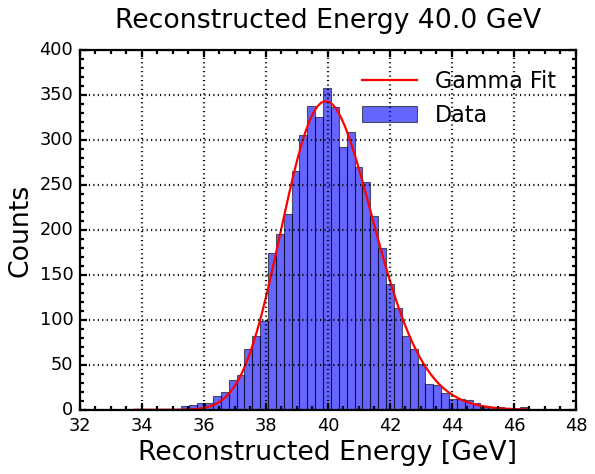

appending results for E = 40.0
Mean_Gamma: 40.157838194620936 Mean_Gamma_Error: 0.02687643531398174
Peak_Gamma: 39.92865474974359 Peak_Gamma_Error: 0.026615712015366028
Mean: 50.15627225389915, Peak: 50.283450243238576, RMS: 1.6636468026261289
Initial Gamma Fit Parameters: [np.float64(1319.2935163015884), np.float64(3.65146130276623), np.float64(44.08153033263907), np.float64(1.6636468026261289)]
Gamma Fit Bounds: lower [np.float64(13.192935163015884), np.float64(-0.634853869723377), np.float64(3.4081530332639067), np.float64(0.1663646802626129)], 
 upper [np.float64(7915.761097809531), np.float64(36.5146130276623), np.float64(76.12229549895861), np.float64(16.636468026261287)]
Gamma Fit Parameters: [1.30230039e+03 3.65146130e+01 4.05326765e+01 2.65256583e-01]
Gamma Fit Peak: 49.95316142322969 ± 0.03417635887063704, Mean: 50.218418006124494 ± 0.034560747877134056, Resolution: 0.03208754885074751 ± 0.00047888677477637677


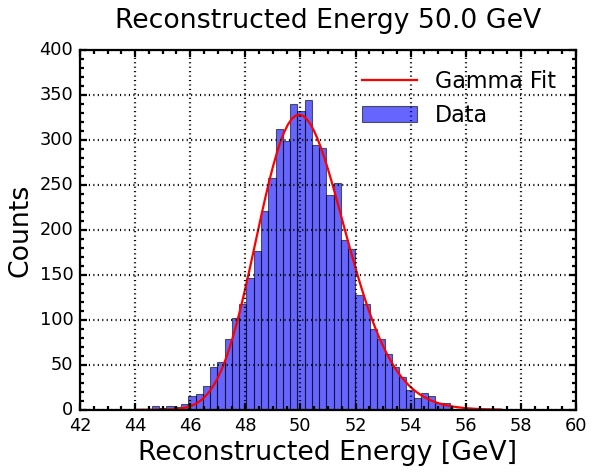

appending results for E = 50.0
Mean_Gamma: 50.218418006124494 Mean_Gamma_Error: 0.034560747877134056
Peak_Gamma: 49.95316142322969 Peak_Gamma_Error: 0.03417635887063704
Mean: 59.657975584377105, Peak: 59.317440800788944, RMS: 1.7404062338591784
Initial Gamma Fit Parameters: [np.float64(1321.3362703249843), np.float64(3.3084307444434007), np.float64(53.89996209245645), np.float64(1.7404062338591784)]
Gamma Fit Bounds: lower [np.float64(13.213362703249842), np.float64(-0.66915692555566), np.float64(4.389996209245645), np.float64(0.17404062338591786)], 
 upper [np.float64(7928.017621949906), np.float64(33.084307444434), np.float64(90.84994313868467), np.float64(17.404062338591785)]
Gamma Fit Parameters: [1.31702099e+03 3.30843074e+01 4.97586486e+01 3.01053609e-01]
Gamma Fit Peak: 59.4177451934348 ± 0.0344508272624076, Mean: 59.718798802793216 ± 0.034880145455908396, Resolution: 0.029143297879807215 ± 0.00040894212255657527


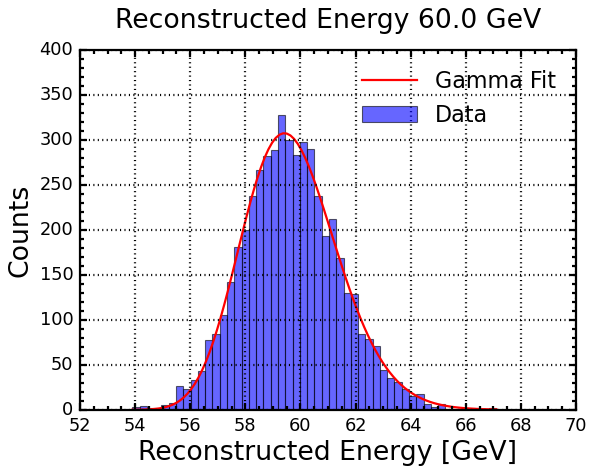

appending results for E = 60.0
Mean_Gamma: 59.718798802793216 Mean_Gamma_Error: 0.034880145455908396
Peak_Gamma: 59.4177451934348 Peak_Gamma_Error: 0.0344508272624076
Results saved to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/Reco_Results/RecoE_MLP_lr1e-3_Fit.csv


In [ ]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
    print(f"Results saved to {CSV_name}")
#outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_{MLP_Config}_Fit.csv")
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit_Threshold{Threshold_i}.csv")
OutputCSV(Reco_hist_mlp_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")